## Components in this RAG project

1. **External Data Source**: `University-of-North-Georgia-Employee-Handbook.pdf`. The text data from the external source is parsed and converted to a numerical representation known as embeddings. The relevant embeddings are then retrieved and integrated with the internal representation of an LLM.
2. **Embedding Model**: An embedding model is used to convert the text data to numerical embeddings, also known as vectors. The SentenceTransformer `sentence-transformers/all-MiniLM-L6-v2` is used in this project.
3. **Vector Document Store**: The embeddings constructed from the external data sources are stored in a vector database to facilitate efficient lookup and similarity search. `InMemoryDocumentStore` is used in this project.
4. **Orchestration Pipeline**: An end-to-end framework is required to extract data and embeddings, seamlessly integrate with the vector document store, apply semantic search on embeddings, and generate responses for scalable, production-ready deployment of RAG. This framework essentially consists of a pipeline that can preprocess the external data, chunk them into sizeable units, convert the text data to numerical embeddings, retrieve the embeddings per user query, and facilitate the integration of the retrieved embeddings with generative AI logic of the LLM. `Haystack` is used in this project.
5. **Large Language Model**: An LLM is at the heart of the RAG framework to power the generative AI mechanism. `GPT-4o-mini` is used in this project.

## Architecture of Haystack AI
Haystack’s architecture is designed to be modular and flexible, allowing developers to build custom pipelines tailored to their specific needs. It is made of two main architectures: components and pipelines.

Here’s a brief overview of some of its key components:
* **Document Store**: The storage system for documents. It can be in-memory or persistent.
* **Retriever**: Finds relevant documents from the document store based on a query.
* **Generator**: Extracts or generates answers from the retrieved documents.
* **Pipeline**: Connects all components in a sequence to process the input query and generate the final output.

Use pip to install the Haystack 2.x with "haystack-ai". Do not use "farm-haystack" which is for Haystack 1.x version.

In [1]:
# %%bash
# pip install haystack-ai
# pip install "sentence-transformers>=2.2.0"

In [2]:
# file_name = '/kaggle/input/employee-handbook/University-of-North-Georgia-Employee-Handbook.pdf'
file_name = 'documents/University-of-North-Georgia-Employee-Handbook.pdf'

## Two Pipelines

1. Indexing Pipeline: preprocess the external data from a pdf file, chunk them into sizeable units, convert the text data to numerical embeddings and save into a vector document store.
2. Query Pipeline: retrieve the embeddings from user question, retrieve relevant documents from the document store, construct a prompt and use a language model to generate an answer.

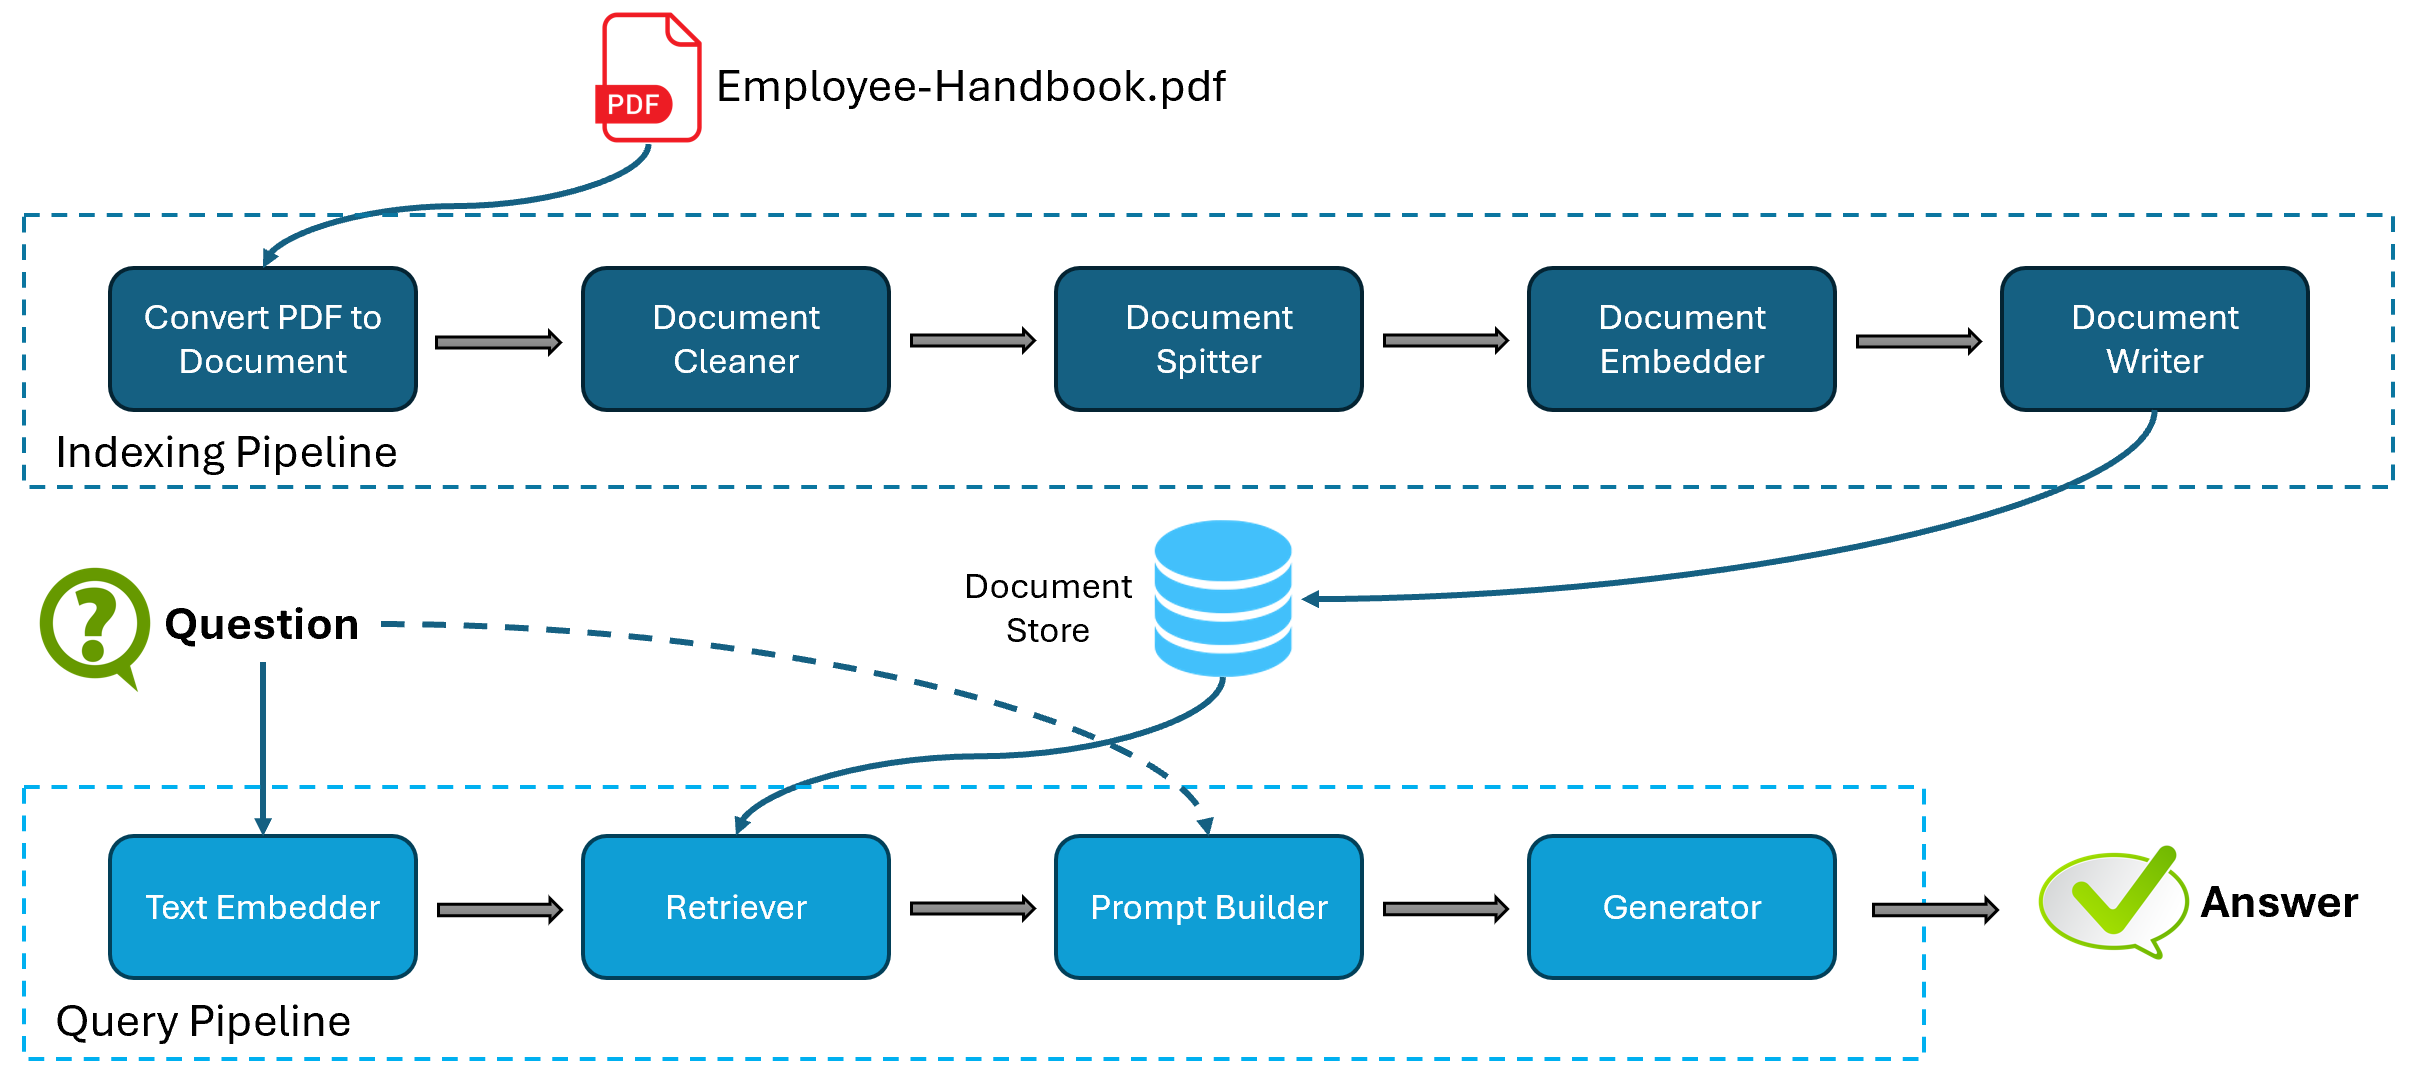

We need to import all necessary libraries from Haystack framework.

In [3]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret
# from kaggle_secrets import UserSecretsClient
import os
from dotenv import load_dotenv
from pathlib import Path
# import pypdf
# from pypdf import PdfReader

c:\TuanTA\ML Projects\NLP Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building Indexing Pipeline

Our indexing pipeline will convert the PDF file into a Haystack Document using PyPDFToDocument and preprocess it by cleaning and splitting it into chunks before storing them in InMemoryDocumentStore.

Use SentenceTransformersTextEmbedder to embed PDF document and store in Document Store.

InMemoryDocumentStore is a pure Python data structures stored in memory. It is ideal for creating quick prototypes with small datasets. It doesn’t require any special setup, and it can be used right away without installing additional dependencies.

In [4]:
document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()

## Add components to the pipeline
indexing_pipeline.add_component("converter", PyPDFToDocument())
indexing_pipeline.add_component("cleaner", DocumentCleaner(
    remove_empty_lines=True, remove_extra_whitespaces=True, remove_repeated_substrings=True))
indexing_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=10, split_overlap=2))
indexing_pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))

## Connect the components to each other
indexing_pipeline.connect("converter", "cleaner")
indexing_pipeline.connect("cleaner", "splitter")
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")

## Run the pipeline with the files you want to index.
result = indexing_pipeline.run({"converter": {"sources": [Path(file_name)]}}) # use Path()
result

Batches: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


{'writer': {'documents_written': 257}}

## Building Query Pipeline

A query pipeline is used to receive a query from the user and produce a result. It has access to a DocumentStore which stores a set of documents. A common query pipeline is designed to return a result based on the documents stored in the DocumentStore it has access to.


In this pipeline, we’ll use `InMemoryEmbeddingRetriever` to retrieve relevant information from the `InMemoryDocumentStore` and a GPT model `GPT-4o-mini` to generate answers with `OpenAIGenerator`.

In [5]:
# user_secrets = UserSecretsClient()
# openai_api_key = Secret.from_token(user_secrets.get_secret("OPEN_API_KEY2"))

load_dotenv(".env")
openai_api_key = Secret.from_token(os.getenv("OPENAI_API_KEY"))

The **prompt template** specifies how the context (retrieved documents) and the question should be formatted. For different business contexts, the prompt templates may vary based on the required level of detail or the desired tone of the answer.
- `documents` is passed from retriever
- `question` is passed as a param in pipeline.run()

In [6]:
template = """
    Synthesize a comprehensive answer from the following text for the given question.
    Provide a clear and concise response that summarizes the key points and information presented in the text.
    Your answer should be in your own words and be no longer than 40 words.
    Context:
    {% for document in documents %}
        {{ document.content }}
    {% endfor %}

    Question: {{question}}
    Answer:
"""

Use `SentenceTransformersTextEmbedder` to embed the question before sending it to a `PromptBuilder`

In [7]:
query_pipeline = Pipeline()

# Add components to your pipeline
query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
query_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=2))
query_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
query_pipeline.add_component("llm", OpenAIGenerator(
    model="gpt-4o-mini",
    api_key=openai_api_key,
    generation_kwargs={"temperature": 0}
))

# Now, connect the components to each other
# connect(input, output)
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
query_pipeline.connect("retriever", "prompt_builder.documents")
query_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [8]:
question = "Is orientation mandatory for a student assistant?"
question = "What are the consequences for non-exempt employees who fail to record their time worked accurately in the OneUSG Connect system?"
question = "How are insurance premiums deducted from the paychecks of bi-weekly paid employees, and how does this differ for monthly staff?"

In [9]:
response = query_pipeline.run(
    {
        "text_embedder":{"text": question},
        "prompt_builder": {"question": question}
    }
)
print(f'🤖 Answer: {response["llm"]["replies"][0]}')

Batches: 100%|██████████| 1/1 [00:00<00:00, 87.82it/s]


🤖 Answer: Bi-weekly employees have medical insurance premiums deducted from their first two paychecks monthly on a pre-tax basis, while monthly staff have premiums deducted on the last working day of the month, also on a pre-tax basis.


## Relevant Documents

In [10]:
retrieval_pipeline = Pipeline()

retrieval_pipeline.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
retrieval_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=1))
retrieval_pipeline.connect("embedder", "retriever")

retrieval_result = retrieval_pipeline.run({"embedder": {"text": question}})

print(f"🧑 Question: {question}")
print(f"🤖 Relevant Documents:")
for doc in retrieval_result["retriever"]["documents"]:
    print(doc.content)
    print("-"*12)

Batches: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]

🧑 Question: How are insurance premiums deducted from the paychecks of bi-weekly paid employees, and how does this differ for monthly staff?
🤖 Relevant Documents:
 Falsification of or failure to record time may result in failure to get paid and/or disciplinary action including termination. ALL TIME RECORDS MUST BE APPROVED BY BOTH THE EMPLOYEE AND AN AUTHORIZED REVIEWING AUTHORITY. 2.11.2 Paychecks Non-exempt employees are paid bi-weekly, with payments made every other Friday. Any pay adjustments not reporting to Payroll Services in time for processing in the current payroll will be reflected on the next paycheck. Insurance premiums are deducted out of the first two paychecks of each month but will be adjusted by payroll as needed to collect any amounts due.Page | 50 Monthly staff are compensated on the last working day of each month that includes premium deductions as needed. 2.11.
------------


## References
1. https://medium.com/deepset-ai/pdf-based-question-answering-with-amazon-bedrock-and-haystack-dc234003ffd8
2. https://medium.com/@researchgraph/a-technical-guide-to-haystack-ai-e1a95bae4d96
3. https://www.e2enetworks.com/blog/rag-implementation-using-mistral-7b-haystack-and-weaviate

## Have Fun with "The Godfather"

We can reuse the same 2 pipelines created above to digest “*Mario_Puzo-The_Godfather.pdf*”. This book is 6 times larger than the handbook, so please expect the preprocessing will take longer.

Take a look at some example questions and answers below. I found out that the RAG technique is not very suitable for Q&A with stories, as the answers often require **inference from multiple parts** of the narrative. In contrast, answers for informational documents, such as handbooks or guides, typically come from just one or two specific sections of the document.

In [11]:
# file_name = '/kaggle/input/pdf-books/pdf/Mario_Puzo-The_Godfather.pdf'
file_name = 'documents/Mario_Puzo-The_Godfather.pdf'

document_store = InMemoryDocumentStore()

result = indexing_pipeline.run({"converter": {"sources": [Path(file_name)]}})
result

Batches: 100%|██████████| 49/49 [00:29<00:00,  1.64it/s]


{'writer': {'documents_written': 1559}}

In [12]:
question = "Who are Don Corleone's children?"
question = "Why has Don Corleone been shot?"
question = "What is unusual about Tom Hagen being chosen for Don Corleone's consigliori?" # In The Godfather
question = "Who are the men writing down license plate numbers outside Connie's wedding?"

response = query_pipeline.run(
    {
        "text_embedder":{"text": question},
        "prompt_builder": {"question": question}
    }
)
print(f'🤖 Answer: {response["llm"]["replies"][0]}')

Batches: 100%|██████████| 1/1 [00:00<00:00, 111.47it/s]


🤖 Answer: The men writing down license plate numbers outside Connie's wedding are assigned by the Don to monitor Carlo Rizzi's bookmaking activities, reporting to Tom Hagen.
